In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [2]:
import zipfile 

In [3]:
zf_train = zipfile.ZipFile('data/train.csv.zip') 
zf_train.extractall()
zf_test = zipfile.ZipFile('data/test.csv.zip')
zf_test.extractall()

In [4]:
from proj1_helpers import *
#PATH1='..\'
DATA_TRAIN_PATH = 'train.csv' # TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [5]:
tX

array([[ 138.47 ,   51.655,   97.827, ...,    1.24 ,   -2.475,  113.497],
       [ 160.937,   68.768,  103.235, ..., -999.   , -999.   ,   46.226],
       [-999.   ,  162.172,  125.953, ..., -999.   , -999.   ,   44.251],
       ...,
       [ 105.457,   60.526,   75.839, ..., -999.   , -999.   ,   41.992],
       [  94.951,   19.362,   68.812, ..., -999.   , -999.   ,    0.   ],
       [-999.   ,   72.756,   70.831, ..., -999.   , -999.   ,    0.   ]])

<ipython-input-6-4b895e4e2df2>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


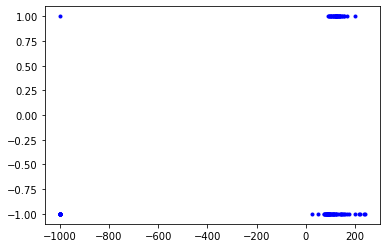

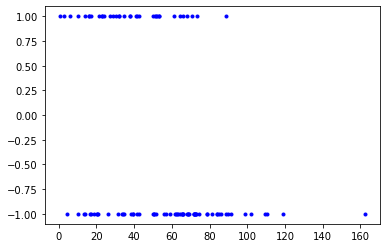

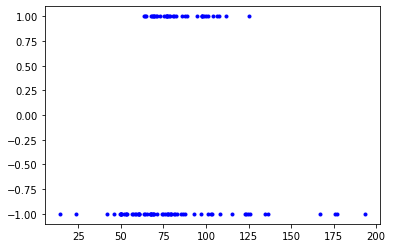

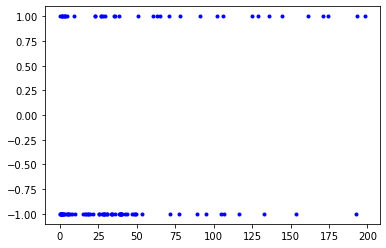

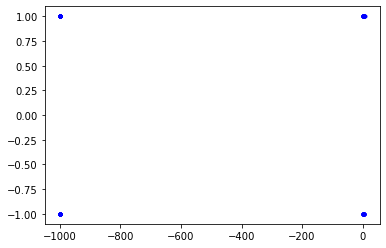

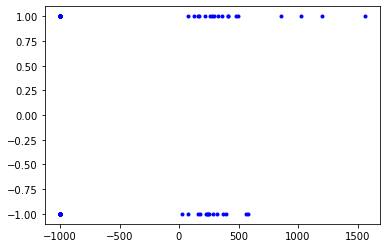

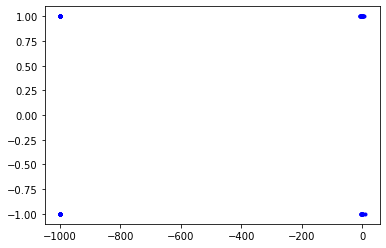

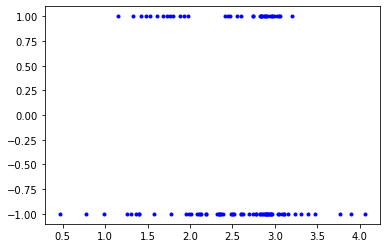

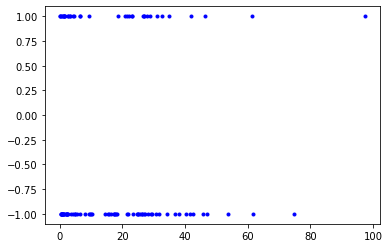

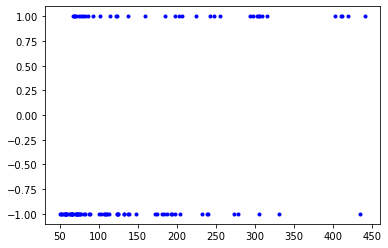

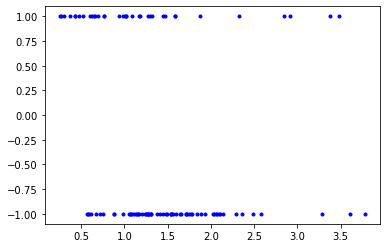

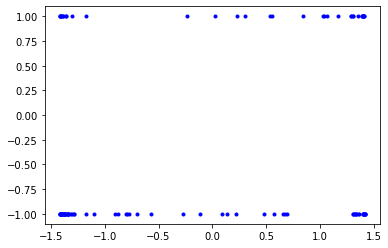

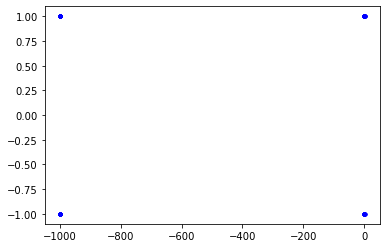

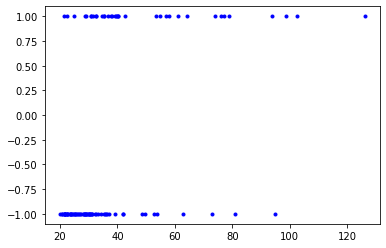

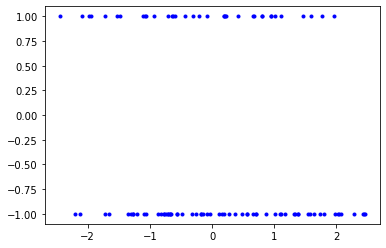

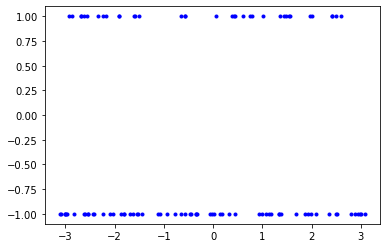

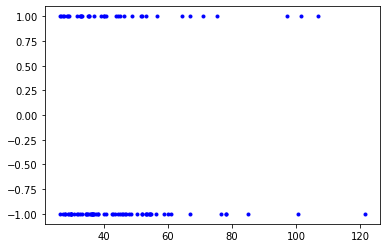

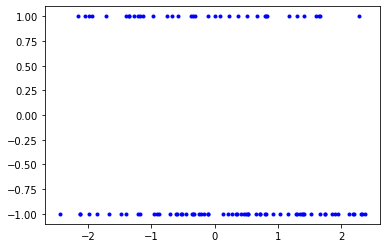

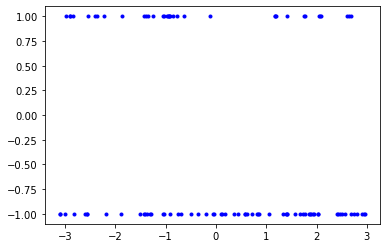

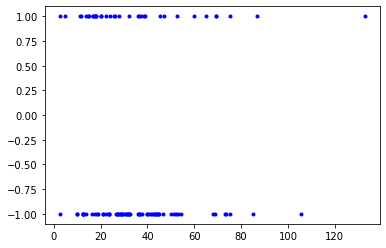

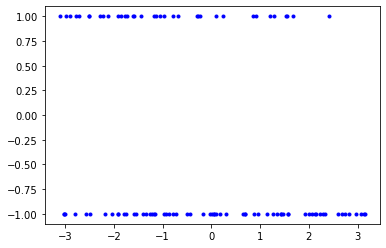

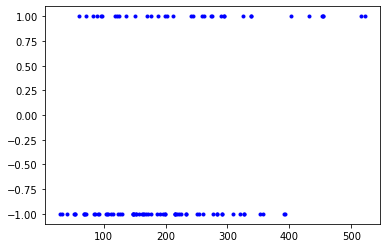

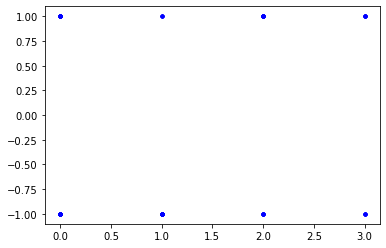

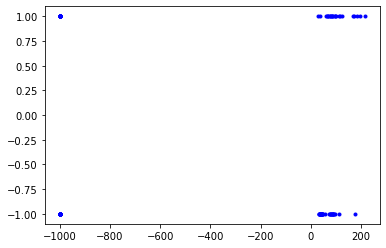

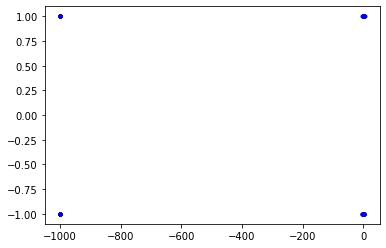

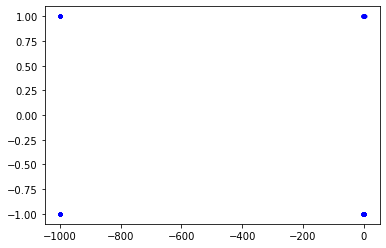

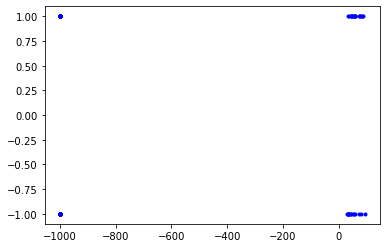

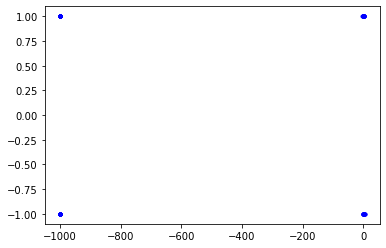

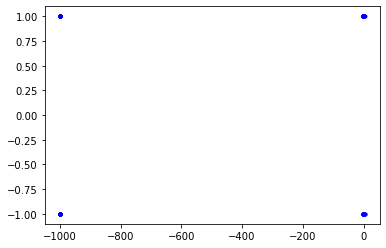

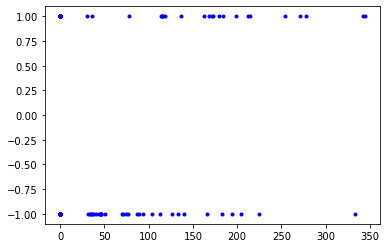

<Figure size 432x288 with 0 Axes>

In [6]:
tX.shape
x_data= tX[0:100]
y_data=y[0:100]

for i in range (0, 30):
    plt.plot(x_data[:,i], y_data, 'b.')
    plt.figure()

In [7]:
#step2

# Linear regression using gradient descent

def compute_loss(y, tx, w):
    y=np.reshape(y, (-1, 1))
    e=y-np.dot(tx,w)
    mse=(1/(2*tx.shape[0]))*np.dot(e.transpose(),e)
    return mse

def compute_gradient(y, tx, w):
    """Compute the gradient."""
    y=np.reshape(y, (-1, 1))
    e=y-np.dot(tx,w)
    L=(-1/tx.shape[0])*np.dot(tx.transpose(), e)
    return L

def least_squares_GD(y, tx, initial_w, max_iters, gamma):
    """Gradient descent algorithm."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    loss=0
    for n_iter in range(max_iters): 
        loss=compute_loss(y, tx, w)
        w= w - (gamma*compute_gradient(y, tx, w))
        ws.append(w)
        losses.append(loss)
        #print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              #bi=n_iter, ti=max_iters - 1, l=loss, w0=ws[0], w1=ws[1]))

    return losses, ws

In [8]:
#Linear regression using stochastic gradient descent

def compute_stoch_gradient(y, tx, w, batch_size):
    l=0
    """Compute a stochastic gradient from just few examples n and their corresponding y_n labels."""
    for minibatch_y, minibatch_tx in batch_iter(y, tx, batch_size):
        l=compute_gradient(minibatch_y, minibatch_tx,w)
        
    return l


def stochastic_gradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
     
    ws = [initial_w]
    losses = []
    w = initial_w
    loss=0
    for n_iter in range(max_iters):
        for minibatch_y, minibatch_tx in batch_iter(y, tx, batch_size):
            loss=compute_loss(minibatch_y, minibatch_tx, w)
            w= w - (gamma*compute_stoch_gradient(minibatch_y, minibatch_tx, w,batch_size))
            ws.append(w)
            losses.append(loss)
        
    return losses, ws


In [9]:
#Least squares regression using normal equations

def least_squares(y, tx):
    """calculate the least squares solution."""
    a = tx.T.dot(tx)
    b = tx.T.dot(y)
    w=np.linalg.solve(a, b)
    loss=compute_loss(y, tx, w)
    return loss, w

In [10]:
#Ridge regression using normal equations

def ridge_regression(y, tx, lambda_):
    """implement ridge regression."""
    aI = lambda_ * np.identity(tx.shape[1])
    a = tx.T.dot(tx) + aI
    b = tx.T.dot(y)
    w= np.linalg.solve(a, b)
    loss=compute_loss(y, tx, w)
    return loss, w


In [11]:
#Logistic regression using gradient descent or SGD

def sigmoid(t):
    return (1+np.exp(-t))**-1

def calculate_loss(y, tx, w):
    S=sigmoid(tx.dot(w))
    loss= y.T.dot(np.log(S))+ (1-y).T.dot(np.log(1-S))
    return np.squeeze(- loss)

def calculate_gradient(y, tx, w):
    
    pred = sigmoid(tx.dot(w))
    grad = tx.T.dot(pred - y)
    return grad

def logistic_regression_loss(y, tx, w):
    """return the loss, gradient, and hessian."""
    loss = calculate_loss(y, tx, w)
    gradient = calculate_gradient(y, tx, w)
    hessian = calculate_hessian(y, tx, w)
    return loss, gradient, hessian

def learning_by_gradient_descent(y, tx, w, gamma):
    """
    Do one step of gradient descen using logistic regression.
    Return the loss and the updated w.
    """
    loss = calculate_loss(y, tx, w)
    grad = calculate_gradient(y, tx, w)
    w -= gamma * grad
    return loss, w

def logistic_regression(y, tx, initial_w, max_iters, gamma):
    # init parameters
    ws = [initial_w]
    losses = []
    w = initial_w
    loss=0

    # build tx
    tx = np.c_[np.ones((y.shape[0], 1)), x]

    # start the logistic regression
    for iter in range(max_iter):
        # get loss and update w.
        loss, w = learning_by_gradient_descent(y, tx, w, gamma)
        ws.append(w)
        losses.append(loss)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    return losses, ws

In [12]:
#Regularized logistic regression using gradient descent or SGD
    
def penalized_logistic_regression(y, tx, w, lambda_):
    """return the loss, gradient"""
    p=sigmoid(tx.dot(w))
    loss= calculate_loss(y, tx, w)+ (lambda_/2)*(la.norm(w)**2)
    grad=calculate_gradient(y, tx, w)+ 2*lambda_*w
    return loss, grad

def learning_by_penalized_gradient(y, tx, w, gamma, lambda_):
    """
    Do one step of gradient descent, using the penalized logistic regression.
    Return the loss and updated w.
    """
    loss, gradient= penalized_logistic_regression(y, tx, w, lambda_)
    w=w-gamma*gradient

    return loss, w

def reg_logistic_regression(y, tx, lambda_ , initial_w, max_iters, gamma):
    # init parameters
    ws = [initial_w]
    losses = []
    w = initial_w
    loss=0

    # build tx
    tx = np.c_[np.ones((y.shape[0], 1)), x]


    # start the logistic regression
    for iter in range(max_iter):
        # get loss and update w.
        loss, w = learning_by_penalized_gradient(y, tx, w, gamma, lambda_)
        ws.append(w)
        # converge criterion
        losses.append(loss)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break


## Do your thing crazy machine learning thing here :) ...

## Generate predictions and save ouput in csv format for submission:

In [13]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    poly = np.ones((len(x), 1))
    for deg in range(1, degree+1):
        poly = np.c_[poly, np.power(x, deg)]
    return poly

def cross_validation(y, x, k_indices, k, lambda_, degree):
    """return the loss of ridge regression."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # get k'th subgroup in test, others in train: TODO
    index_te = k_indices[k]
    index_tr = k_indices[~(np.arange(k_indices.shape[0]) == k)]
    index_tr = index_tr.reshape(-1)
    x_te=x[index_te]
    y_te=y[index_te]
    tx_te= build_poly(x_te, degree)
    x_tr=x[index_tr]
    y_tr=y[index_tr]
    tx_tr= build_poly(x_tr, degree)
    w = ridge_regression(y_tr, tx_tr, lambda_)
    loss_tr = np.sqrt(2 * compute_mse(y_tr, tx_tr, w))
    loss_te = np.sqrt(2 * compute_mse(y_te, tx_te, w))
    
    return loss_tr, loss_te


In [14]:
max_iters = 100
gamma = 0.01
initial_w = np.zeros((tX.shape[1], 1))

gradient_losses, gradient_ws = least_squares_GD(y, tX, initial_w, max_iters, gamma)

In [7]:
DATA_TEST_PATH = 'test.csv' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [31]:
OUTPUT_PATH = '' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)